# School Safety - Part 3
### *Assessing Racial Bias Via MCA/Clustering*

## 1. Background
The Department of Education conducts a periodic survey of public schools in the country: The School Survey on Crime and Safety (SSOCS). More information on this survey can be found [here](https://nces.ed.gov/surveys/ssocs/index.asp?FType=3). For this project, I downloaded cross-sectional data from the 2015-2016 school year. The relevant files are available directly in my GitHub repository, although they can also be manually downloaded from the National Center for Education Statistics (NCES) [website](https://nces.ed.gov/pubsearch/pubsinfo.asp?pubid=2018109). After some preliminary analysis, I chose to focus on three main questions:

1. Is it possible to predict how many violent incidents a school will have in a given year?
2. Is it possible to predict the extent to which bullying occurs at a school?
3. Is there discrimination based on race when it comes to disciplinary action at schools?

This notebook will focus on developing insights for the third question above. I used the following methodology to detect bias in schools:

1. For each school size (FR_SIZE=1 through 4), isolate rows corresponding to that size.
2. For each size group, reduce the dimensionality of the dataset, while maintaining 70% of the total variance.
2. On the reduced dimensionality data, cluster similar schools together.
3. For each cluster, find the mean value of various disciplinary statistics grouped by the percentage of white students (PERCWHT). If a clear pattern is visible based on race, this suggests bias.

**The analysis resulted in the following conclusions:**
1. In general, there does seem to be a pattern that as PERCWHT goes from 1 (>95% white) to 4 (<=50% white), the average number of incidents increases.
2. At large schools, there is evidence of racial bias in the average number of incidents reported to the police.
3. When looking at the proportion of total incidents reported to police, the pattern seems to reverse for some clusters. There are several clusters where the proportion is decreasing as the percentage of white students decreases. However, this may still be a sign of bias.

## 2. Setup/Data Cleaning

The following [module](https://pypi.org/project/sas7bdat/) needs to be installed in order to read the original data file:

```pip install sas7bdat```

I manually went through the column description list (**column_descriptions.docx** in this repository) and saved information for relevant columns in **select_columns_clustering.csv**. Each row contains the following info:
1. **Variable**: The coded representation of the survey question
2. **Label**: Description of the survey question
3. **Binary**: A value of 1 means that the variable takes on Y/N values
4. **Dummy**: A value of 1 means that the variable is categorical but not in Y/N format (these will need to be expanded into dummy representations)
5. **Create_Buckets**: A value of 1 means that this is a continuous numerical variable which will need to be manually grouped into a finite number of categorical buckets.

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

pd.options.display.max_columns = 17

In [218]:
from sas7bdat import SAS7BDAT
reader = SAS7BDAT('school_safety.sas7bdat', skip_header=False)
X_cluster = reader.to_data_frame()

bias_df = X_cluster[["FR_SIZE","PERCWHT","INCID16","INCPOL16"]]
bias_df["PROP_REPORTED_POL"] = bias_df["INCPOL16"]/bias_df["INCID16"]
#Create empty cluster column (to be filled later)
bias_df["cluster"]=np.nan

select_columns_clustering = pd.read_csv("select_columns_clustering.csv")
X_cluster = X_cluster[select_columns_clustering["Variable"]]

#Drop any columns with missing (-1) values
X_cluster = X_cluster.loc[:,~(X_cluster==-1).any()]

C:\Users\Sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Sahil\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Next, for the continuous numerical columns, I decided to group values into 4 buckets based on quartiles.

In [175]:
cols_to_bucket = select_columns_clustering["Variable"][select_columns_clustering["Create_Buckets"]==1]
for col in cols_to_bucket:
    X_cluster[col] = pd.qcut(X_cluster[col], q=4, labels=False, duplicates="drop")

In [176]:
#Convert the FR_LVEL column from object to numeric type
X_cluster["FR_LVEL"] = pd.to_numeric(X_cluster["FR_LVEL"])

Finally, I separated columns into binary vs non-binary and performed the same value conversion/dummy creation as in the previous two parts of this project. All columns then had to be converted back into the category data type for compatibility with the following analysis.

In [177]:
binary_cols = [col for col in X_cluster.columns if X_cluster[col].isin([1,2]).all()]
non_binary_cols = [col for col in X_cluster.columns if not X_cluster[col].isin([1,2]).all()]

#Convert Y/N columns to Y=1 and N=0
X_cluster[binary_cols] = X_cluster[binary_cols].applymap(lambda x: 1 if x==1 else 0)

#Convert non-binary columns to dummy columns and drop the first dummy column
X_cluster = pd.get_dummies(X_cluster, drop_first=True, columns=non_binary_cols)

#Convert all columns to category dtype
X_cluster = X_cluster.astype("category")

## 3. Multiple Correspondence Analysis/K-Means Clustering

The following [module](https://pypi.org/project/prince/) needs to be installed for multiple correspondence analysis (MCA):

```pip install prince```

MCA is essentially an extension of principal component analysis (PCA) to categorical variables. It allowed me to reduce the dimensionality of my data set which both improved clustering performance and made visualization easier. Initially, my data had 168 columns. I chose to use the common cutoff of 70% retained variance for each school size group. For FR_SIZE=1, this meant using 44 components. I used 53, 60, and 57 components respectively for FR_SIZE=2,3,4.

In [178]:
import prince
mca_dfs=[]
for school_size, n_components in [(1,44), (2,53), (3,60), (4,57)]:
    X_cluster_subset = X_cluster[bias_df["FR_SIZE"]==school_size]
    mca = prince.MCA(n_components=n_components, n_iter=30, copy=True, check_input=True, random_state=21, engine="auto")
    mca.fit(X_cluster_subset)
    print("FR_SIZE: "+str(school_size)+"; Retained Variance: " + str(sum(mca.explained_inertia_)))
    mca_dfs.append(mca.transform(X_cluster_subset))

FR_SIZE: 1; Retained Variance: 0.7019307106538613
FR_SIZE: 2; Retained Variance: 0.7031397734688991
FR_SIZE: 3; Retained Variance: 0.7008322159711871
FR_SIZE: 4; Retained Variance: 0.7002023146550506


With the MCA reduced dataset, I moved onto performing a k-means clustering to group similar schools together. I ran this for several values of k and plotted the total error.

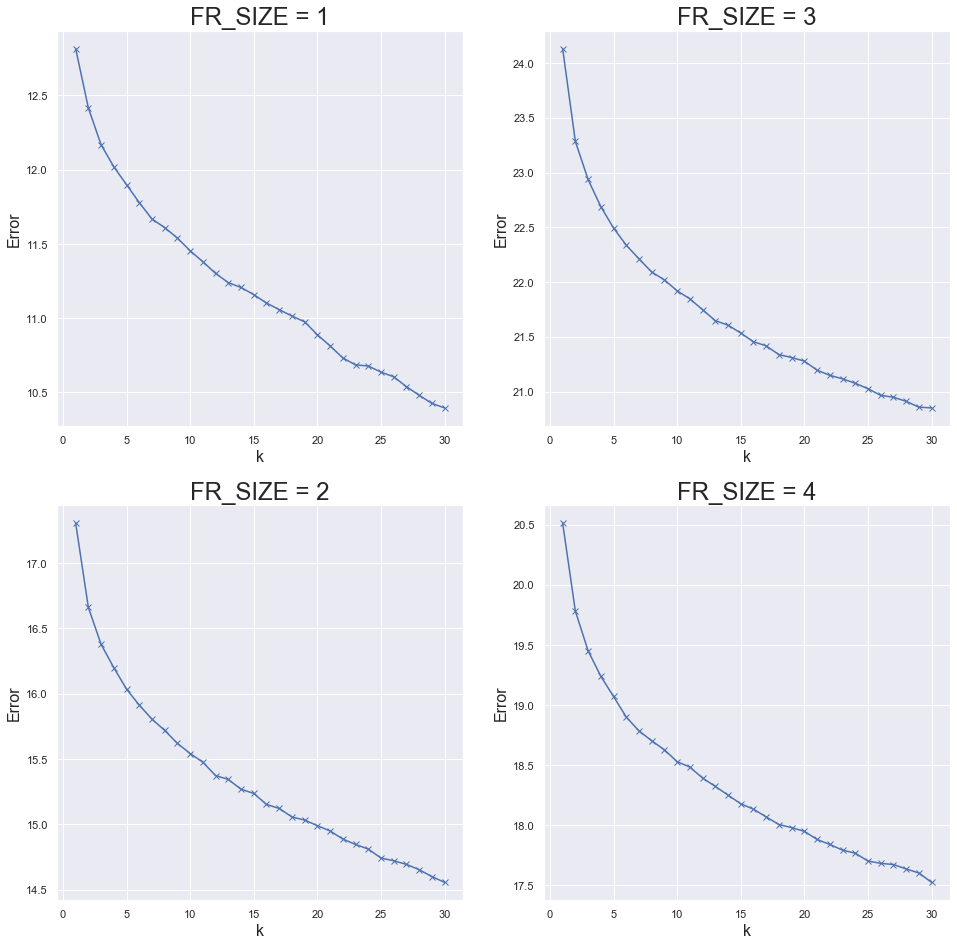

In [128]:
from sklearn.cluster import KMeans
fig, ax = plt.subplots(2,2,figsize=(16,16))
for i, mca_df in enumerate(mca_dfs):
    fr_size = i+1
    error = []
    K = range(1,31)
    axis = ax[i%2,i//2]
    
    for k in K:
        km = KMeans(n_clusters=k, random_state=14)
        km = km.fit(mca_df)
        error.append(km.inertia_**.5)
    
    axis.plot(K, error, 'bx-')
    axis.set_xlabel('k',fontsize=16)
    axis.set_ylabel('Error',fontsize=16)
    axis.set_title('FR_SIZE = '+str(fr_size),fontsize=24)

The graphs above have an elbow shape around a value of k=5. Thus, I assigned each MCA reduced data point to one of five clusters. For each value of FR_SIZE, I then visualized these clusters in 2 and 3 dimensions by isolating the first few MCA components.

In [179]:
#Cluster schools within each school size group. Assign the clusters back to the bias_df column for plotting.
cluster_list = []

for mca_df in mca_dfs:
    km = KMeans(n_clusters=5, random_state=14)
    cluster = km.fit_predict(mca_df)
    cluster_list.append(cluster)
    mca_df["cluster"] = cluster
    bias_df.loc[mca_df.index,"cluster"]=cluster

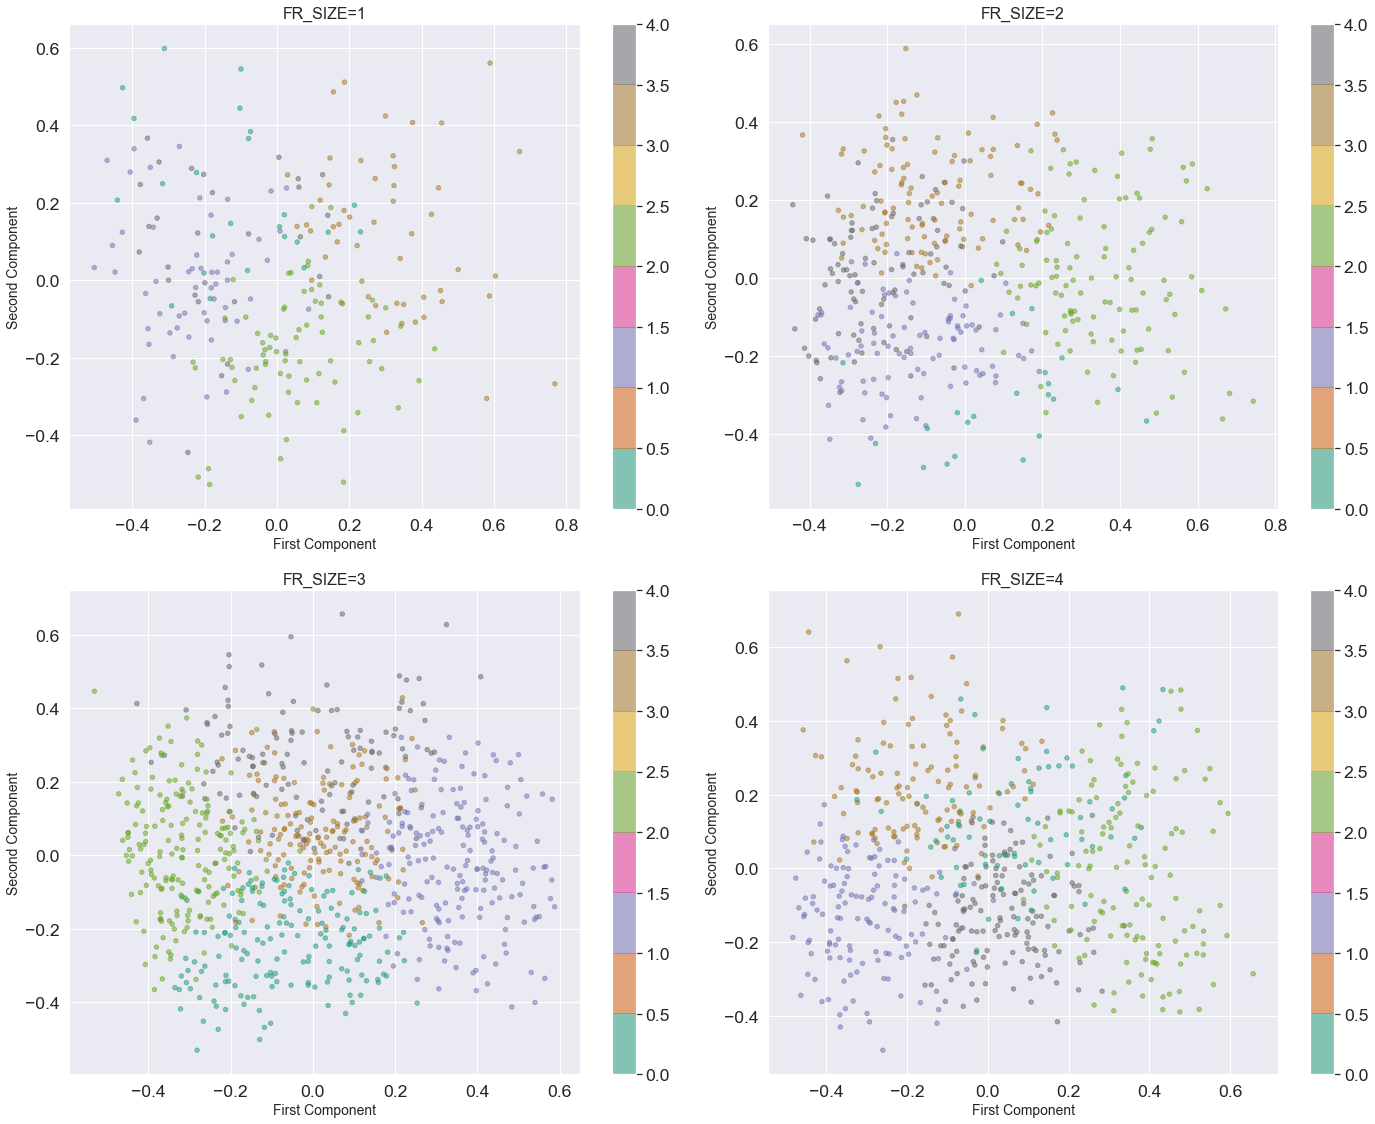

In [226]:
#2-dimensional cluster visualization
fig,ax=plt.subplots(2,2,figsize=(20,16))


for i, mca_df in enumerate(mca_dfs):
    axis = ax[i//2,i%2]
    mca_df.plot.scatter(x=0,y=1, color=mca_df["cluster"], colormap="Dark2", alpha=.5, ax=axis)
    axis.set_title("FR_SIZE="+str(i+1),fontsize=16)
    axis.set_xlabel("First Component",fontsize=14)
    axis.set_ylabel("Second Component",fontsize=14)
    
fig.tight_layout()

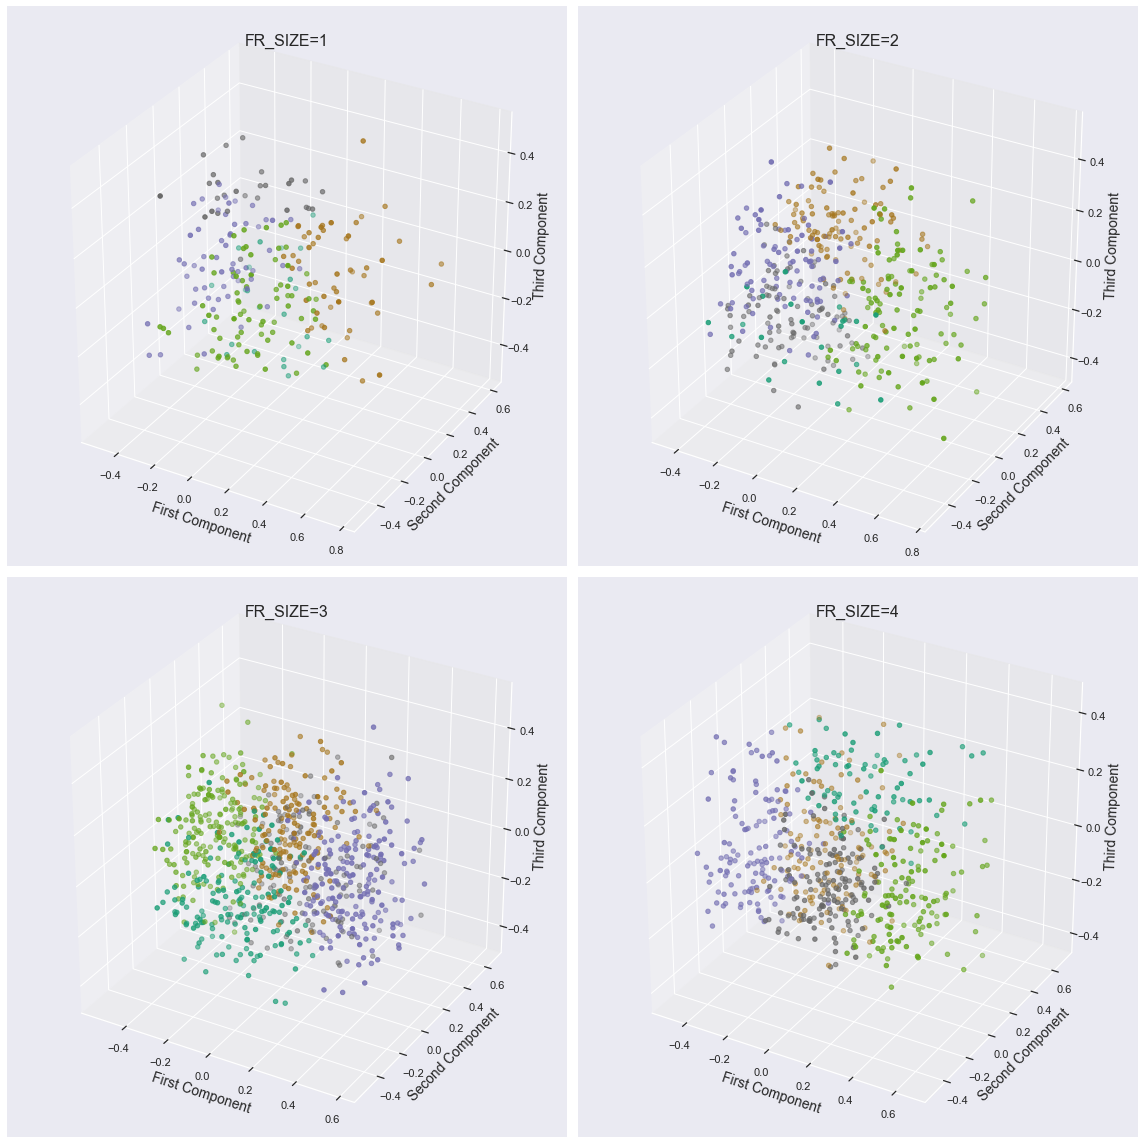

In [201]:
#3-dimensional cluster visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,16))

for i, mca_df in enumerate(mca_dfs):
    ax3D = fig.add_subplot(2,2,i+1, projection='3d')
    p3d = ax3D.scatter(mca_df[0],mca_df[1],mca_df[2], c=mca_df["cluster"], cmap="Dark2")  
    ax3D.set_title("FR_SIZE="+str(i+1),fontsize=16)
    ax3D.set_xlabel("First Component",fontsize=14)
    ax3D.set_ylabel("Second Component",fontsize=14)
    ax3D.set_zlabel("Third Component",fontsize=14)
    
fig.tight_layout()

## 4. Racial Bias Analysis

Next, I grouped schools by size, cluster, and percent white (in that order) and calculated the mean for the disciplinary statistic columns. This is saved in **bias_df_grouped**. The function **bias_plot** then takes a disciplinary stat as an input and builds four rows of bar charts visualizing the stat across school size, cluster, and race.

In [210]:
bias_df_grouped = bias_df.groupby(["FR_SIZE","cluster","PERCWHT"],as_index=False).mean()
bias_df_grouped

,FR_SIZE,cluster,PERCWHT,INCID16,INCPOL16,PROP_REPORTED_POL
0,1.0,0.0,1,9.000000,0.000000,0.000000
1,1.0,0.0,2,0.000000,0.000000,NaN
2,1.0,0.0,3,7.200000,0.800000,0.121053
3,1.0,0.0,4,11.312500,1.562500,0.226300
4,1.0,1.0,1,1.666667,0.333333,0.133333
...,...,...,...,...,...,...
73,4.0,3.0,4,53.151515,32.060606,0.534286
74,4.0,4.0,1,31.500000,28.500000,0.900000
75,4.0,4.0,2,31.566667,20.466667,0.654134
76,4.0,4.0,3,47.625000,32.208333,0.623019


In [212]:
def bias_plot(bias_col):
    sns.set(font_scale=1.6)
    sns.catplot(x = "cluster",
            y = bias_col,
            hue = "PERCWHT",
            row="FR_SIZE",
            data = bias_df_grouped,
            kind = "bar", sharey = False, sharex=False, height=4, aspect=4)

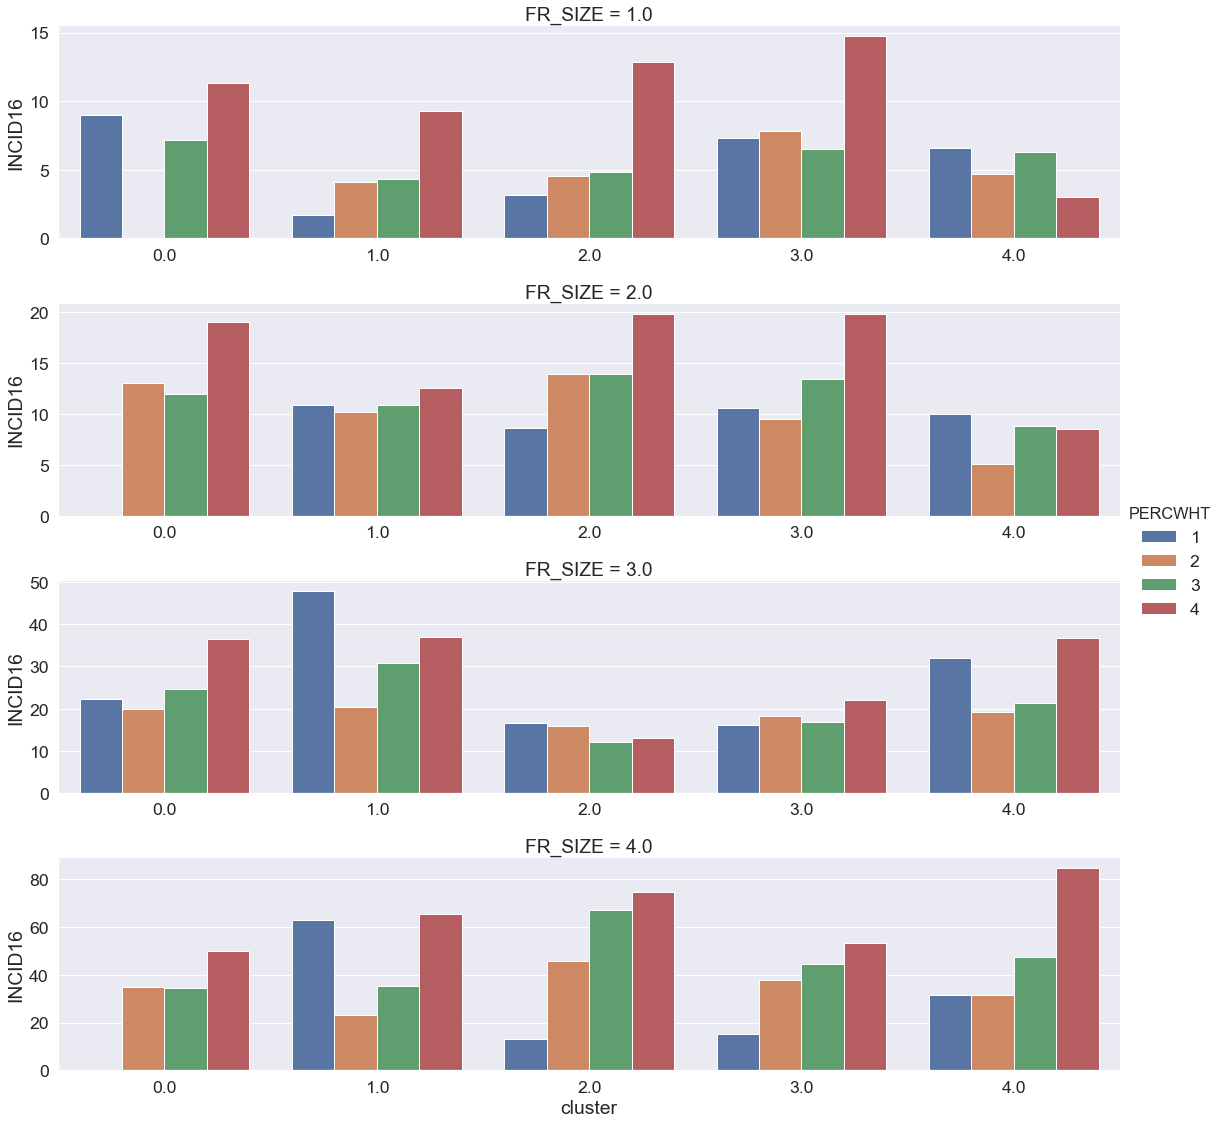

In [213]:
#Plot total number of incidents
bias_plot("INCID16")

In general, there does seem to be a pattern that as PERCWHT goes from 1 (>95% white) to 4 (<=50% white), the average number of incidents increases. This pattern is most pronounced for FR_SIZE = 1, 2, and 4, while FR_SIZE = 3 does not display any majors patterns.

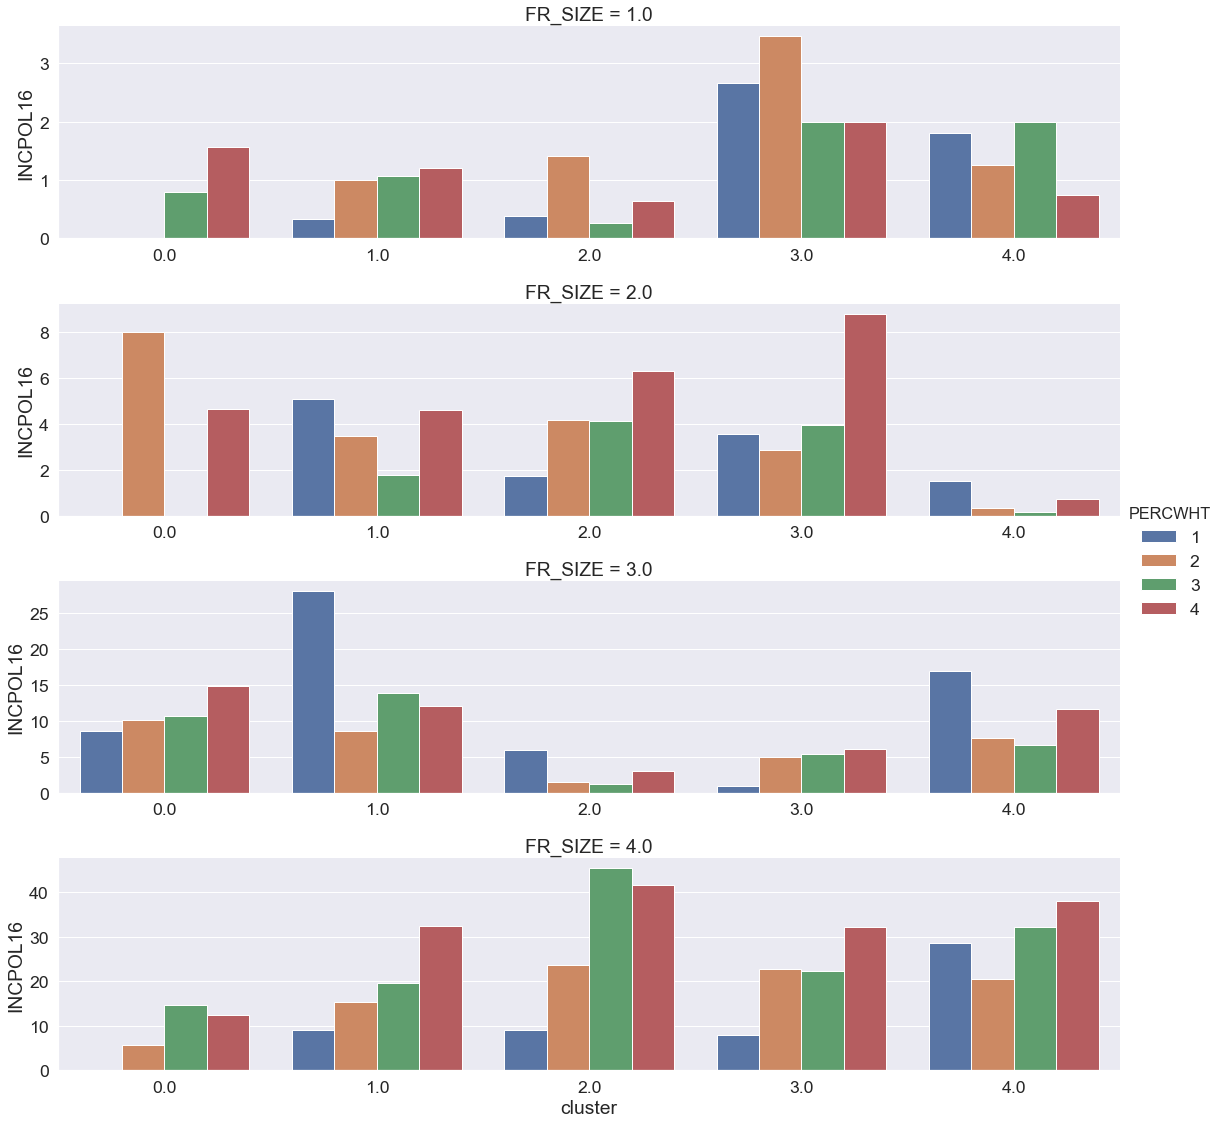

In [215]:
#Plot number of incidents reported to police
bias_plot("INCPOL16")

The above plot is a bit more sparse (due to either some clusters not containing all PERCWHT values or some clusters having only schools with 0 incident reported to police). The most clear trend of bias is visible in the largest schools (FR_SIZE=4), a moderate trend is visible for FR_SIZE=2, and no clear trend is visible in the other categories.

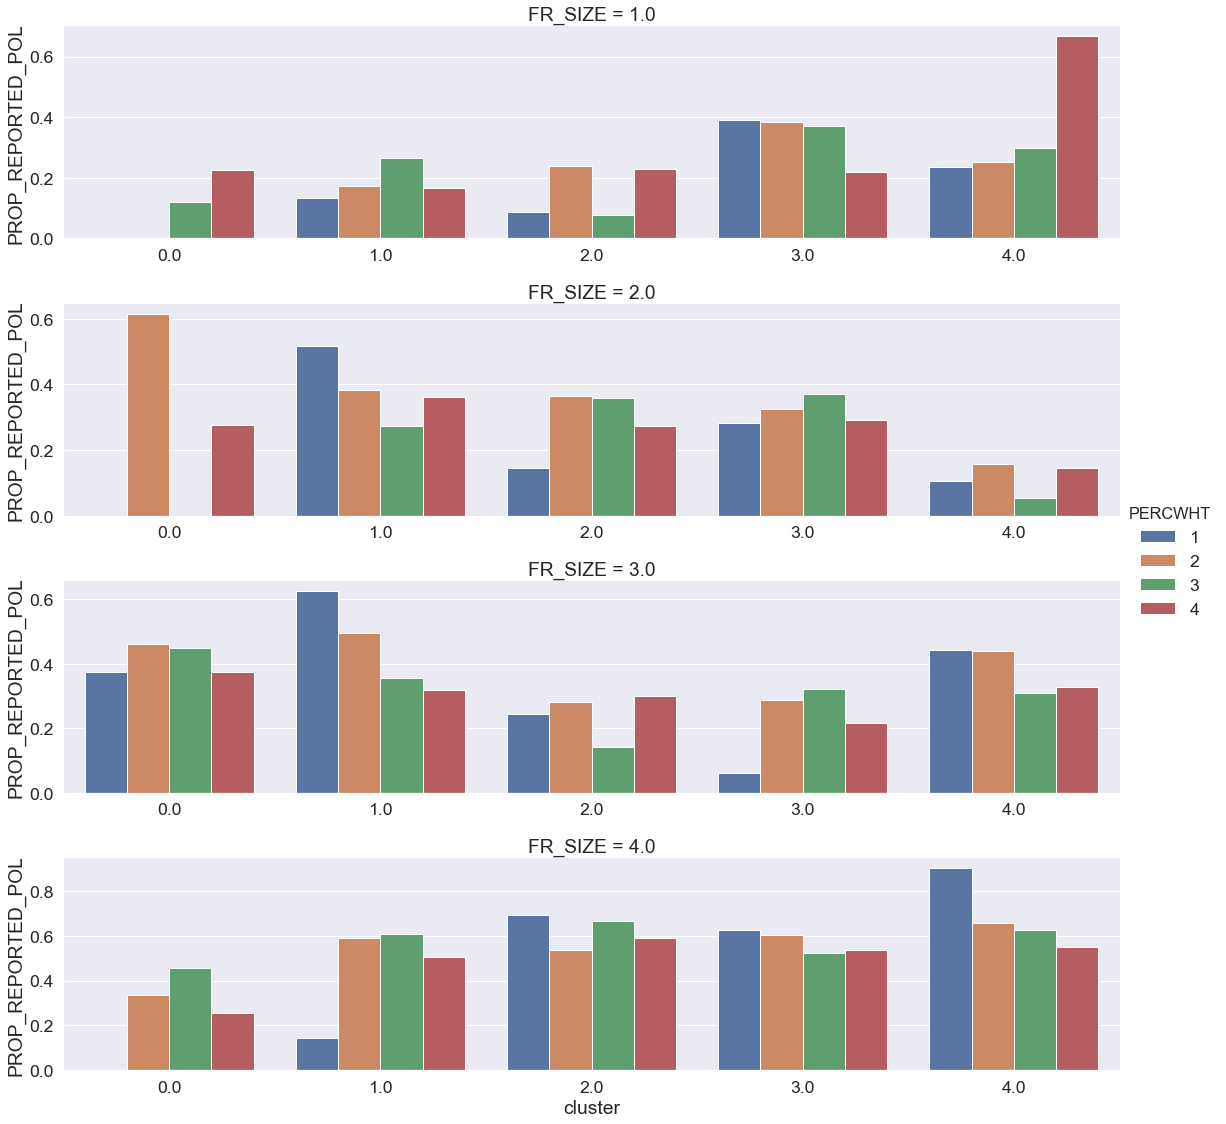

In [216]:
#Plot proportion of total incidents that were reported to police
bias_plot("PROP_REPORTED_POL")

Interestingly, when looking at the proportion of total incidents reported to police, the pattern seems to reverse for some clusters. Specifically, for FR_SIZE 2 through 4, there are several clusters where the proportion is decreasing as the percentage of white students decreases (PERCWHT increases). Does this still suggest disciplinary bias? Perhaps schools with more white students only flag serious incidents (which results in a larger likelihood of being reported to police). On the other hand, schools with less white students may flag both serious and not serious incidents (which results in a lower proportion being reported to police). However, without more data granularity, it is difficult to make a more robust conclusion.

## 5. Conclusion/Further Steps



There does seem to be some evidence of bias in disciplinary action based on racial makeup of schools after holding other variables constant. As a next step, I would like to look into the standard error of the bars created above to see how statistically significant these differences are. It would also be interesting to see how disciplinary action varies based on other demographic variables such as proportion of students in ESL programs (included in this dataset), religious affiliation (not included), etc.